In [1]:
import os
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
from scipy.fft import fft
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib import rcParams
from scipy.io import savemat
from scipy.ndimage import shift
#from google.colab import drive
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, GRU
from sklearn.preprocessing import StandardScaler
from scipy.signal import correlate, correlation_lags
from scipy.signal import butter, lfilter, freqz, lfilter_zi
from keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings("ignore")
import sys
import os
# Obtener la ruta del directorio actual
os.chdir('/home/rgadea/experimentos_software_2024')
current_dir = os.getcwd()
print(current_dir)

2024-05-20 14:41:05.882000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 14:41:05.882068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 14:41:05.884971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 14:41:05.899598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 14:41:06.882521: W tensorflow/comp

/home/rgadea/experimentos_software_2024


In [2]:
tf.config.list_physical_devices('GPU')


2024-05-20 14:41:12.736511: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-20 14:41:12.736724: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: nodofpga-2024.novalocal
2024-05-20 14:41:12.736770: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: nodofpga-2024.novalocal
2024-05-20 14:41:12.737158: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-05-20 14:41:12.737423: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-05-20 14:41:12.737468: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.161.7


[]

***Functions***

In [3]:
def plot_measurement(meas_variable, ylabel, type, *numb):
    meas_ID = df.MAHLE_ID.unique()
    meas_ID.sort()
    n_meas_ID = len(meas_ID)
    mpl.style.use('ggplot')
    [figure, axes] = plt.subplots(int(np.ceil(n_meas_ID / 4)), 4)
    axes = axes.flatten()

    for i, exp in enumerate(meas_ID):
        m_df = df[df['MAHLE_ID'] == exp]
        axes[i].set_title(f'sample {exp}')
        for measurement in meas_variable:
            axes[i].plot(m_df[measurement], label=measurement)
            axes[i].grid()
            axes[i].set_ylabel(ylabel)

    axes.flat[-1].set_visible(False)  # to remove last plot
    axes.flat[-2].set_visible(False)
    figure.set_size_inches(10, 12)
    lines, labels = figure.axes[0].get_legend_handles_labels()
    figure.legend(lines, labels, loc='upper center', ncol=4)
    plt.subplots_adjust(left=0.08, bottom=0.053, right=0.985, top=0.918, wspace=0.44, hspace=0.455)

    if type == 'r':
        type = 'Raw'
    if type == 'f':
        type = 'Filter'
    if type == 'n':
        type = 'Norm'
        figure.set_size_inches(10, 10)
        plt.subplots_adjust(left=0.08, bottom=0.010, right=1.8, top=0.918, wspace=0.44, hspace=0.255)
    if type == 'dn':
        type = 'Denorm'
        axes.flat[-3].set_visible(False)
        figure.set_size_inches(10, 10)
        plt.subplots_adjust(left=0.08, bottom=0.010, right=4, top=0.918, wspace=0.44, hspace=0.255)

    if ylabel == 'Temp (C)':
        plt.savefig(f'{path_plots}/{type}_Measurements_{ylabel}_{numb}.jpg', bbox_inches='tight')
        plt.savefig(f'{path_plots}/{type}_Measurements_{ylabel}_{numb}.pdf', bbox_inches='tight')
    else:
        plt.savefig(f'{path_plots}/{type}_Measurements_{ylabel}.jpg', bbox_inches='tight')
        plt.savefig(f'{path_plots}/{type}_Measurements_{ylabel}.pdf', bbox_inches='tight')

In [4]:
def normalization(data, *train):
    if train:
        scaler.fit(data)
    norm = scaler.transform(data)
    return norm

In [5]:
def denormalization(data):
    dummy = np.zeros((len(data), scaler.n_features_in_))
    dummy[:, -len(NN_output_col):] = data
    d_norm = scaler.inverse_transform(dummy)[:, -len(NN_output_col):]
    return d_norm

In [6]:
def model_plots(model):
    validation_pred = denormalization(model.predict(validation_generator))
    test_pred = denormalization(model.predict(test_generator))

    model.save(f'{path_results}/model.h5')
    model.save(f'{path_results}/model')

    plt.figure
    plt.title(f'Temperature Prediction (Validation: exp 14)')
    plt.xlabel('Time step')
    plt.ylabel(f'Temp (°C)')
    plt.plot(y_validation[:, 0], label=f'temp_stator_phaseA_sideA_real', color='r')
    plt.plot(validation_pred[:, 0], label=f'temp_stator_phaseA_sideA_pred', color='b')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'{path_plots}/temp_stator_phaseA_sideA_exp14.png')
    plt.savefig(f'{path_plots}/temp_stator_phaseA_sideA_exp14.pdf')

    plt.figure
    plt.title(f'Temperature Prediction (Validation: exp 14)')
    plt.xlabel('Time step')
    plt.ylabel(f'Temp (°C)')
    plt.plot(y_validation[:, 1], label=f'temp_stator_phaseA_sideB_real', color='r')
    plt.plot(validation_pred[:, 1], label=f'temp_stator_phaseA_sideB_pred', color='b')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'{path_plots}/temp_stator_phaseA_sideB_exp14.png')
    plt.savefig(f'{path_plots}/temp_stator_phaseA_sideB_exp14.pdf')

    plt.figure
    plt.title(f'Temperature Prediction (Validation: exp 14)')
    plt.xlabel('Time step')
    plt.ylabel(f'Temp (°C)')
    plt.plot(y_validation[:, 2], label=f'temp_stator_phaseA_center_real', color='r')
    plt.plot(validation_pred[:, 2], label=f'temp_stator_phaseA_center_pred', color='b')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'{path_plots}/temp_stator_phaseA_center_exp14.png')
    plt.savefig(f'{path_plots}/temp_stator_phaseA_center_exp14.pdf')

    plt.figure
    plt.title(f'Temperature Prediction (Validation: exp 14)')
    plt.xlabel('Time step')
    plt.ylabel(f'Temp (°C)')
    plt.plot(y_validation[:, 3], label=f'temp_rotor_center_real', color='r')
    plt.plot(validation_pred[:, 3], label=f'temp_rotor_center_pred', color='b')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'{path_plots}/temp_rotor_center_exp14.png')
    plt.savefig(f'{path_plots}/temp_rotor_center_exp14.pdf')

    plt.figure
    plt.title(f'Temperature Prediction (Validation: exp 8)')
    plt.xlabel('Time step')
    plt.ylabel(f'Temp (°C)')
    plt.plot(y_test[:, 0], label=f'temp_stator_phaseA_sideA_real', color='r')
    plt.plot(test_pred[:, 0], label=f'temp_stator_phaseA_sideA_pred', color='b')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'{path_plots}/temp_stator_phaseA_sideA_exp8.png')
    plt.savefig(f'{path_plots}/temp_stator_phaseA_sideA_exp8.pdf')

    plt.figure
    plt.title(f'Temperature Prediction (Validation: exp 8)')
    plt.xlabel('Time step')
    plt.ylabel(f'Temp (°C)')
    plt.plot(y_test[:, 1], label=f'temp_stator_phaseA_sideB_real', color='r')
    plt.plot(test_pred[:, 1], label=f'temp_stator_phaseA_sideB_pred', color='b')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'{path_plots}/temp_stator_phaseA_sideB_exp8.png')
    plt.savefig(f'{path_plots}/temp_stator_phaseA_sideB_exp8.pdf')

    plt.figure
    plt.title(f'Temperature Prediction (Validation: exp 8)')
    plt.xlabel('Time step')
    plt.ylabel(f'Temp (°C)')
    plt.plot(y_test[:, 2], label=f'temp_stator_phaseA_center_real', color='r')
    plt.plot(test_pred[:, 2], label=f'temp_stator_phaseA_center_pred', color='b')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'{path_plots}/temp_stator_phaseA_center_exp8.png')
    plt.savefig(f'{path_plots}/temp_stator_phaseA_center_exp8.pdf')

    plt.figure
    plt.title(f'Temperature Prediction (Validation: exp 8)')
    plt.xlabel('Time step')
    plt.ylabel(f'Temp (°C)')
    plt.plot(y_test[:, 3], label=f'temp_rotor_center_real', color='r')
    plt.plot(test_pred[:, 3], label=f'temp_rotor_center_pred', color='b')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'{path_plots}/temp_rotor_center_exp8.png')
    plt.savefig(f'{path_plots}/temp_rotor_center_exp8.pdf')




***Database***

In [23]:
# drive.mount('/content/gdrive/', force_remount=True)
df = pd.read_csv('measures_v2.csv')
path_plots = 'PLOTS'
path_results = 'results2'
#path_plots = 'C:/Users/16pao/OneDrive/Escritorio/FINAL/Plots'
#df = pd.read_csv('Data/measures_v2.csv')

selected_variables = {'u_q': 'voltage_q_sp',
                      'coolant': 'temp_coolant',
                      'stator_winding': 'temp_stator_phaseA_sideA',
                      'stator_tooth': 'temp_stator_phaseA_center',
                      'u_d': 'voltage_d_sp',
                      'motor_speed': 'speed_fb',
                      'i_d': 'current_d_sp',
                      'i_q': 'current_q_sp',
                      'pm': 'temp_rotor_center',
                      'stator_yoke': 'temp_stator_phaseA_sideB',
                      'ambient': 'temp_amb',
                      'torque': 'torque_fb',
                      'profile_id': 'MAHLE_ID',
                      }

df.rename(columns=selected_variables, inplace=True)
mahle_id = df['MAHLE_ID']
df.head()

,voltage_q_sp,temp_coolant,temp_stator_phaseA_sideA,voltage_d_sp,temp_stator_phaseA_center,speed_fb,current_d_sp,current_q_sp,temp_rotor_center,temp_stator_phaseA_sideB,temp_amb,torque_fb,MAHLE_ID
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


***Exploratory Data Analysis***

mean: 2.678776167471819


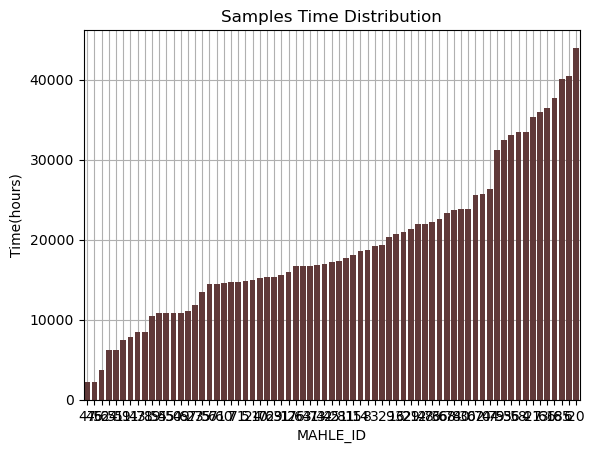

In [8]:
ddf = df.groupby('MAHLE_ID').size().reset_index(name='hours')
ddf['hours'] /= 7200
mean = sum(ddf['hours']) / len(ddf['hours'])
print("mean:", mean)

color = (0.4, # redness
         0.2, # greenness
         0.2, # blueness
         1 # transparency
         )

df_ord = df.groupby(['MAHLE_ID']).size().sort_values().rename('Time(hours)').reset_index()
orderly = df_ord.MAHLE_ID.values.tolist()
histogram = sns.barplot(y='Time(hours)', x='MAHLE_ID', data=df_ord, order=orderly, color=color, orient='v')
plt = histogram.set_title('Samples Time Distribution')
histogram.set_axisbelow(True)
histogram.grid(zorder=0)
rcParams['figure.figsize'] = 50,5
#plt.savefig(f'{path_plots}/samples_time_duration.jpg', bbox_inches='tight')
#plt.savefig(f'{path_plots}/samples_time_duration.pdf', bbox_inches='tight')

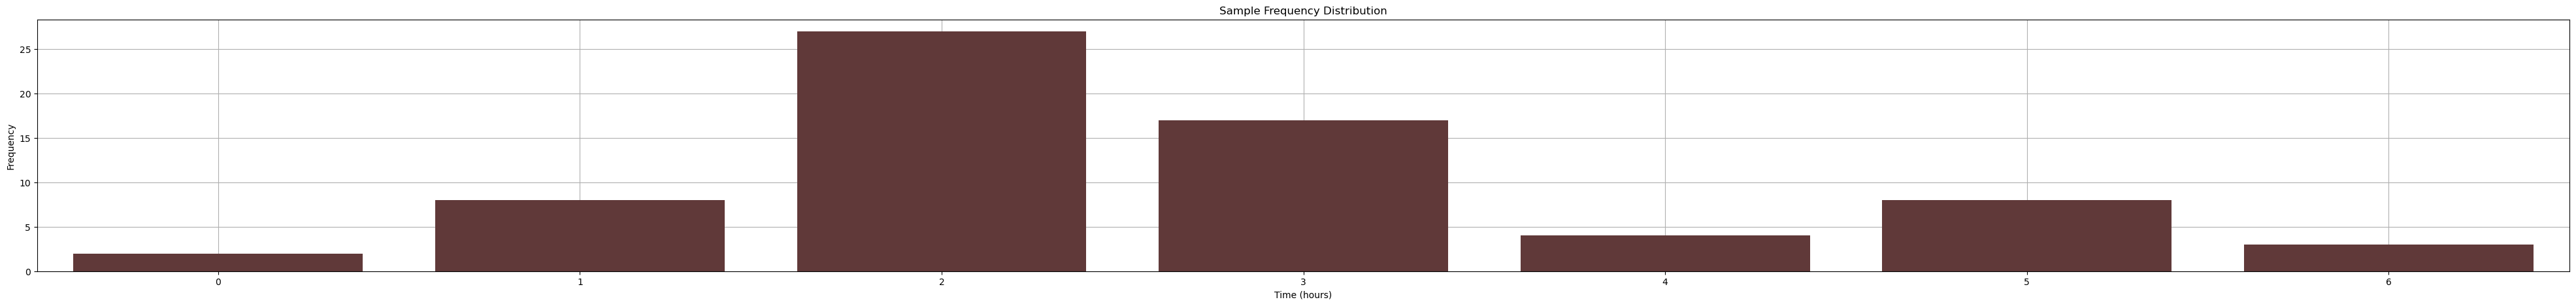

In [9]:
ddf['hours'] = ddf['hours'].apply(round)

histogram_frec = sns.countplot(x='hours', data=ddf, color=color)
histogram_frec.set_axisbelow(True)
histogram_frec.grid(zorder=0)
histogram_frec.set_title('Sample Frequency Distribution')
histogram_frec.set_ylabel('Frequency')
histogram_frec.set_xlabel('Time (hours)')
rcParams['figure.figsize'] = 5,3
#plt.savefig(f'{path_plots}/Samples_time_frequency.jpg', bbox_inches='tight')
#plt.savefig(f'{path_plots}/Samples_time_frequency.pdf', bbox_inches='tight')

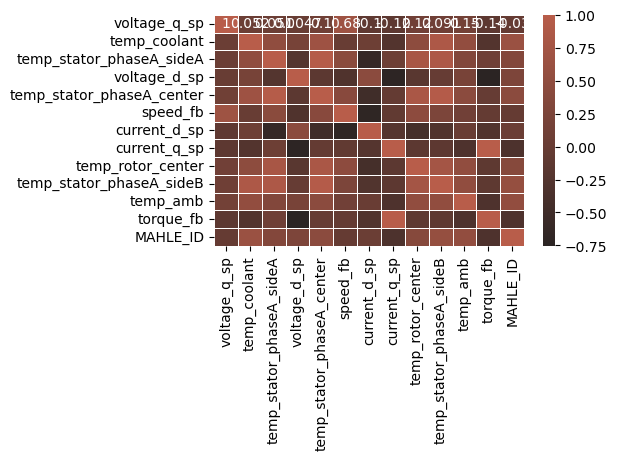

In [10]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True,linewidths=.5, cmap=sns.dark_palette((20, 60, 50), input="husl",as_cmap=True))
rcParams['figure.figsize'] = 14,10
#plt.savefig(f'{path_plots}/Correlation_Matrix_Pearson.jpg', bbox_inches='tight')
#plt.savefig(f'{path_plots}/Correlation_Matrix_Pearson.pdf', bbox_inches='tight')

***Feature Engineering***

In [11]:
df['i_abs'] = np.sqrt(np.power(df['current_d_sp'], 2) + np.power(df['current_q_sp'], 2))
df['u_abs'] = np.sqrt(np.power(df['voltage_d_sp'], 2) + np.power(df['voltage_q_sp'], 2))
df['power'] = df['i_abs'] * df['u_abs']
df['flux'] = df['current_d_sp']-(np.power(df['current_q_sp'], 2)/df['current_d_sp'])
df['joint_1'] = df['i_abs']*df['speed_fb']
df['joint_2'] = df['power']*df['speed_fb']
#print('Values of new variable:\n', df['i_abs'], '\n')
#print('Values of new variable:\n', df['u_abs'], '\n')
#print('Values of new variable:\n', df['power'], '\n')
df.head()
df.describe()

,voltage_q_sp,temp_coolant,temp_stator_phaseA_sideA,voltage_d_sp,temp_stator_phaseA_center,speed_fb,current_d_sp,current_q_sp,temp_rotor_center,temp_stator_phaseA_sideB,temp_amb,torque_fb,MAHLE_ID,i_abs,u_abs,power,flux,joint_1,joint_2
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01,1.075446e+02,8.164042e+01,1.096400e+04,7.597422e+01,2.974634e+05,3.695418e+07
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01,8.526254e+01,5.333507e+01,1.032528e+04,1.886135e+02,3.203572e+05,4.257752e+07
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00,3.922213e-05,1.732221e-06,2.019537e-09,-1.877064e+02,-2.722055e+03,-2.623191e+04
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01,1.182819e+01,1.890028e+01,2.944109e+02,-7.273905e+01,5.705244e+03,2.285750e+05
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01,1.106200e+02,1.077091e+02,9.418585e+03,-1.398572e+00,1.908402e+05,1.882571e+07
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01,1.721419e+02,1.307828e+02,1.888446e+04,2.900668e+02,5.042002e+05,6.620190e+07
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01,3.615153e+02,1.342641e+02,4.761210e+04,4.435569e+02,1.218436e+06,1.584170e+08


***Training/Validation DataFrame***

In [12]:
Redundancy = True

if Redundancy:
    NN_input_col = ['current_d_sp',  'current_q_sp', 'voltage_d_sp', 'voltage_q_sp','torque_fb',  'speed_fb', 'i_abs',
                    'u_abs', 'power','flux', 'joint_1', 'joint_2']
else:
    NN_input_col = ['current_d_sp', 'current_q_sp']

NN_output_col = ['temp_stator_phaseA_sideA', 'temp_stator_phaseA_sideB', 'temp_stator_phaseA_center', 'temp_rotor_center']
df = df[['MAHLE_ID'] + NN_input_col + NN_output_col]
print('Training/Validation DataFrame:\n')
df.head()

Training/Validation DataFrame:



,MAHLE_ID,current_d_sp,current_q_sp,voltage_d_sp,voltage_q_sp,torque_fb,speed_fb,i_abs,u_abs,power,flux,joint_1,joint_2,temp_stator_phaseA_sideA,temp_stator_phaseA_sideB,temp_stator_phaseA_center,temp_rotor_center
0,17,0.004419,0.000328,-0.350055,-0.450682,0.187101,0.002866,0.004431,0.570659,0.002529,0.004395,1.269819e-05,7.246341e-06,19.086670,18.316547,18.293219,24.554214
1,17,0.000606,-0.000785,-0.305803,-0.325737,0.245417,0.000257,0.000992,0.446789,0.000443,-0.000412,2.547010e-07,1.137975e-07,19.092390,18.314955,18.294807,24.538078
2,17,0.001290,0.000386,-0.372503,-0.440864,0.176615,0.002355,0.001346,0.577165,0.000777,0.001174,3.170383e-06,1.829834e-06,19.089380,18.326307,18.294094,24.544693
3,17,0.000026,0.002046,-0.316199,-0.327026,0.238303,0.006105,0.002046,0.454893,0.000931,-0.163541,1.248905e-05,5.681180e-06,19.083031,18.330833,18.292542,24.554018
4,17,-0.064317,0.037184,-0.332272,-0.471150,0.208197,0.003133,0.074292,0.576530,0.042832,-0.042820,2.327433e-04,1.341835e-04,19.082525,18.326662,18.291428,24.565397


In [13]:
# Select Signals for train, validation and test

data = set(list(range(2, 71)))
vt_data = [8, 14]
validation_data = vt_data[0]
test_data = vt_data[1]
training_data = list(set(data) - set(vt_data))
print('Training data:\n', training_data, '\n'
      'Validation data:\n', validation_data, '\n'
      'Test data:\n', test_data, '\n'
      )

Training data:
 [2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70] 
Validation data:
 8 
Test data:
 14 



In [14]:
# Select DataFrames for train, validation and test

training_data = df[df.MAHLE_ID.isin(training_data)].drop(columns=['MAHLE_ID'])
validation_data = df[df.MAHLE_ID.isin([validation_data])].drop(columns=['MAHLE_ID'])
test_data = df[df.MAHLE_ID.isin([test_data])].drop(columns=['MAHLE_ID'])

***Normalization***

In [15]:
# preprocess normalization/denormalize

scaler = StandardScaler()
training_data = normalization(training_data, 1)
#df.to_csv("training_data.csv")
validation_data = normalization(validation_data)
#df.to_csv("validation_data.csv")
test_data = normalization(test_data)

In [16]:
Saving_Normalization_plots = False

if Saving_Normalization_plots:
    # Prepare DataFrame only for plot normalization
    df = pd.DataFrame(training_data).rename(columns={0: 'current_d_sp', 1: 'current_q_sp', 2: 'voltage_d_sp', 3: 'voltage_q_sp',
                                                     4: 'torque_fb', 5: 'speed_fb', 6: 'i_abs', 7: 'u_abs',
                                                     8: 'power', 9: 'temp_stator_phaseA_center',
                                                     10: 'temp_rotor_center'})

    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(mahle_id).rename(columns={0: 'MAHLE_ID'}).reset_index(drop=True)], axis=1)
    df = df[df.MAHLE_ID.isin([2, 3, 4, 5, 6, 7, 8])]

# Plot normalization measurements
    plot_measurement(['current_d_sp',  'current_q_sp'], 'Current(A)', 'n')
    plot_measurement(['torque_fb',  'speed_fb'], 'rpm', 'n')
    plot_measurement(['temp_stator_phaseA_center'], 'Temp (C)', 'n', 'stator')
    plot_measurement(['temp_rotor_center'], 'Temp (C)', 'n', 'rotor')


***Model*** ***Paramenters***

In [17]:
n_time_steps = 128
batch_size = 529
n_features = training_data.shape[1] - len(NN_output_col)
print('Number of Time Steps:', n_time_steps, '\n'
      'Batch Size:', batch_size, '\n'
      'Number of Features:', n_features, '\n'
      )

Number of Time Steps: 128 
Batch Size: 529 
Number of Features: 12 



In [18]:
# Prepare data time series for batches

xtraining_generator = TimeseriesGenerator(training_data[:, :-len(NN_output_col)], training_data[:, -len(NN_output_col):], length=n_time_steps, batch_size=batch_size, shuffle=True)
validation_generator = TimeseriesGenerator(validation_data[:, :-len(NN_output_col)], validation_data[:, -len(NN_output_col):], length=n_time_steps, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_data[:, :-len(NN_output_col)], test_data[:, -len(NN_output_col):], length=n_time_steps, batch_size=batch_size)

mdic = {'x_training_generator': xtraining_generator, 'y_validation_generator': validation_generator, 'y_test_generator': test_generator}
#savemat('input_generator_slx.mat', mdic)

***Denormalization***

In [19]:
# preprocess denormalize outputs to compare

y_validation = denormalization(validation_generator.targets)[n_time_steps:]
y_test = denormalization(test_generator.targets)[n_time_steps:]

mdic = {'y_validation': y_validation, 'y_test': y_test}
#savemat('input_slx.mat', mdic)

In [20]:
Saving_Denormalization_plots = False

if Saving_Denormalization_plots:

    # Prepare DataFrame only for plot denormalize (Validation)
    df = pd.DataFrame(y_validation).rename(columns={0: 'temp_stator_phaseA_center', 2: 'temp_rotor_center'})
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame((np.ones((len(y_validation), n_features)))*14,  dtype=int).rename(columns={0: 'MAHLE_ID'}).reset_index(drop=True)], axis=1)

# Plot denormalization measurements
    plot_measurement(['temp_stator_phaseA_center'], 'Temp (C)', 'dn', 'stator_val')
    #plot_measurement(['temp_rotor_center'], 'Temp (C)', 'dn', 'rotor_val')

    # Prepare DataFrame only for plot denormalize (Test)
    df = pd.DataFrame(y_test).rename(columns={ 0: 'temp_stator_phaseA_center', 1: 'temp_rotor_center'})
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame((np.ones((len(y_validation), n_features)))*8,  dtype=int).rename(columns={0: 'MAHLE_ID'}).reset_index(drop=True)], axis=1)


***Model*** ***Arquitecture***

In [21]:
model = Sequential()
model.add(Input((n_time_steps, n_features)))

# Select the type of architecture
nn_architecture = 2

if nn_architecture == 1:
    model.add((LSTM(256, activation='tanh', return_sequences=True)))
    model.add(Dense(len(NN_output_col), activation='linear'))

if nn_architecture == 2:
    model.add((LSTM(256, activation='tanh', return_sequences=True)))
    model.add((LSTM(256, activation='tanh', return_sequences=False)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(NN_output_col), activation='linear'))

if nn_architecture == 3:
    model.add((GRU(256, activation='tanh', return_sequences=True)))
    model.add((GRU(256, activation='tanh', return_sequences=False)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(NN_output_col), activation='linear'))

if nn_architecture == 4:
    model.add((GRU(256, activation='sigmoid', return_sequences=True)))
    model.add((GRU(256, activation='sigmoid', return_sequences=False)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(NN_output_col), activation='linear'))

In [22]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Loss function (regression)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# Reduce learning rate when learning stagnates
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-6)

# Stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

model.fit(xtraining_generator, validation_data=validation_generator, epochs=40,
          verbose=1, callbacks=[reduce_lr, early_stopping])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 256)          275456    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 837924 (3.20 MB)
Trainable params: 837924 (3.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
2091/2091

PermissionDeniedError: /results2; Permission denied

In [24]:
model_plots(model)

35/35 [==============================] - 29s 829ms/step
INFO:tensorflow:Assets written to: results2/model/assets


INFO:tensorflow:Assets written to: results2/model/assets


AttributeError: 'Text' object has no attribute 'Figure'

In [26]:
Figure()
plt.title(f'Temperature Prediction (Validation: exp 14)')
plt.xlabel('Time step')
plt.ylabel(f'Temp (°C)')
plt.plot(y_validation[:, 0], label=f'temp_stator_phaseA_sideA_real', color='r')
plt.plot(validation_pred[:, 0], label=f'temp_stator_phaseA_sideA_pred', color='b')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'{path_plots}/temp_stator_phaseA_sideA_exp14.png')
plt.savefig(f'{path_plots}/temp_stator_phaseA_sideA_exp14.pdf')

plt.figure
plt.title(f'Temperature Prediction (Validation: exp 14)')
plt.xlabel('Time step')
plt.ylabel(f'Temp (°C)')
plt.plot(y_validation[:, 1], label=f'temp_stator_phaseA_sideB_real', color='r')
plt.plot(validation_pred[:, 1], label=f'temp_stator_phaseA_sideB_pred', color='b')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'{path_plots}/temp_stator_phaseA_sideB_exp14.png')
plt.savefig(f'{path_plots}/temp_stator_phaseA_sideB_exp14.pdf')

plt.figure
plt.title(f'Temperature Prediction (Validation: exp 14)')
plt.xlabel('Time step')
plt.ylabel(f'Temp (°C)')
plt.plot(y_validation[:, 2], label=f'temp_stator_phaseA_center_real', color='r')
plt.plot(validation_pred[:, 2], label=f'temp_stator_phaseA_center_pred', color='b')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'{path_plots}/temp_stator_phaseA_center_exp14.png')
plt.savefig(f'{path_plots}/temp_stator_phaseA_center_exp14.pdf')

plt.figure
plt.title(f'Temperature Prediction (Validation: exp 14)')
plt.xlabel('Time step')
plt.ylabel(f'Temp (°C)')
plt.plot(y_validation[:, 3], label=f'temp_rotor_center_real', color='r')
plt.plot(validation_pred[:, 3], label=f'temp_rotor_center_pred', color='b')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'{path_plots}/temp_rotor_center_exp14.png')
plt.savefig(f'{path_plots}/temp_rotor_center_exp14.pdf')

plt.figure
plt.title(f'Temperature Prediction (Validation: exp 8)')
plt.xlabel('Time step')
plt.ylabel(f'Temp (°C)')
plt.plot(y_test[:, 0], label=f'temp_stator_phaseA_sideA_real', color='r')
plt.plot(test_pred[:, 0], label=f'temp_stator_phaseA_sideA_pred', color='b')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'{path_plots}/temp_stator_phaseA_sideA_exp8.png')
plt.savefig(f'{path_plots}/temp_stator_phaseA_sideA_exp8.pdf')

plt.figure
plt.title(f'Temperature Prediction (Validation: exp 8)')
plt.xlabel('Time step')
plt.ylabel(f'Temp (°C)')
plt.plot(y_test[:, 1], label=f'temp_stator_phaseA_sideB_real', color='r')
plt.plot(test_pred[:, 1], label=f'temp_stator_phaseA_sideB_pred', color='b')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'{path_plots}/temp_stator_phaseA_sideB_exp8.png')
plt.savefig(f'{path_plots}/temp_stator_phaseA_sideB_exp8.pdf')

plt.figure
plt.title(f'Temperature Prediction (Validation: exp 8)')
plt.xlabel('Time step')
plt.ylabel(f'Temp (°C)')
plt.plot(y_test[:, 2], label=f'temp_stator_phaseA_center_real', color='r')
plt.plot(test_pred[:, 2], label=f'temp_stator_phaseA_center_pred', color='b')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'{path_plots}/temp_stator_phaseA_center_exp8.png')
plt.savefig(f'{path_plots}/temp_stator_phaseA_center_exp8.pdf')

plt.figure
plt.title(f'Temperature Prediction (Validation: exp 8)')
plt.xlabel('Time step')
plt.ylabel(f'Temp (°C)')
plt.plot(y_test[:, 3], label=f'temp_rotor_center_real', color='r')
plt.plot(test_pred[:, 3], label=f'temp_rotor_center_pred', color='b')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'{path_plots}/temp_rotor_center_exp8.png')
plt.savefig(f'{path_plots}/temp_rotor_center_exp8.pdf')

AttributeError: 'Text' object has no attribute 'title'